In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import Normalizer, StandardScaler
import random
import findspark
findspark.init()

import time

kafka_topic_name = "songTopic"
kafka_bootstrap_servers = 'localhost:9092'


scala_version = '2.12'
spark_version = '3.2.1'
packages = [ f'org.apache.spark:spark-sql-kafka-0-10_{scala_version}:{spark_version}' , 'org.apache.kafka:kafka-clients:3.3.1' ]

spark = SparkSession \
        .builder \
        .appName("Spotify Streaming Reccomendation System") \
        .config("spark.jars.packages", ",".join(packages))\
        .master("local[*]") \
        .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

# Construct a streaming DataFrame that reads from test-topic
songs_df = spark \
        .readStream \
        .format("kafka") \
        .option("kafka.bootstrap.servers", kafka_bootstrap_servers) \
        .option("subscribe", kafka_topic_name) \
        .option("startingOffsets", "latest") \
        .load()



In [2]:
songs_df1 = songs_df.selectExpr("CAST(value AS STRING)", "timestamp")


songs_schema_string = "order_id INT,id STRING, name STRING,popularity INT, duration_ms DOUBLE, explicit INT, " \
                           + "artists STRING, id_artists STRING, release_date STRING, " \
                           + "danceability DOUBLE," \
                           + "energy DOUBLE, key INT, loudness DOUBLE, " \
                           + "mode INT," \
                           + "speechiness DOUBLE," \
                           + "acousticness DOUBLE, instrumentalness DOUBLE, liveness DOUBLE, " \
                           + "valence DOUBLE, tempo DOUBLE, time_signature DOUBLE"



songs_df2 = songs_df1 \
        .select(from_csv(col("value"), songs_schema_string) \
                .alias("song"), "timestamp")

#song value has same miss
songs_df3 = songs_df2.select("song.*", "timestamp")


In [3]:
def simple():    
    songs_df3.createOrReplaceTempView("song_find");
    song_find_text = spark.sql("SELECT name, artists FROM song_find")
    songs_agg_write_stream = song_find_text \
            .writeStream \
            .trigger(processingTime='5 seconds') \
            .outputMode("update") \
            .option("truncate", "false") \
            .format("console") \
            .start()

    songs_agg_write_stream.awaitTermination(1)

    print("Songs Streaming...")
    
def csv_output():    
    song_find_text = spark.sql("SELECT name, artists FROM song_find")
    songs_agg_write_stream = song_find_text \
            .writeStream \
            .trigger(processingTime='5 seconds') \
            .outputMode("append") \
            .option("truncate", "false") \
            .option("path",'answ') \
            .option("checkpointLocation", "checkpoint_path") \
            .format("csv") \
            .start()

    songs_agg_write_stream.awaitTermination(1)

    print("Songs Streaming...")

In [4]:
songs_df3.createOrReplaceTempView("song_find");
song_find_text = spark.sql("SELECT * FROM song_find")

In [5]:
from random import randint
randNum=str(randint(0,10000))
query_song_aggs = "queryNumber"+randNum

In [6]:
songs_agg_write_stream = song_find_text \
        .writeStream \
        .trigger(processingTime='5 seconds') \
        .outputMode("append") \
        .option("truncate", "false") \
        .format("memory") \
        .queryName(query_song_aggs) 


In [7]:
query_1=songs_agg_write_stream.start()
query_1.awaitTermination(1)

False

In [9]:
spark.sql(f"SELECT * FROM {query_1.name}").toPandas()

,order_id,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,timestamp
0,0,3BFRqZFLSrqtQr6cjHbAxU,Ain't Misbehavin',51.0,237773.0,0,FatsWaller,DYWCXTkNqGFZIfSrWEa,1926,0.515,...,-16.918,0.0,0.0575,0.821,0.001930,0.1900,0.350,98.358,4.000,2022-11-07 11:53:57.830
1,1,61znp1Iy11bdJ2YAbwaqw7,Sing,NaN,NaN,51,520133,0,BennyGoodman,NaN,...,0.744,2.0,-9.1890,0.000,0.066200,0.8470,0.892,0.145,0.259,2022-11-07 11:53:58.846
2,2,0RNxWy0PC3AyH4ThH3aGK6,Mack the Knife,55.0,201467.0,0,LouisArmstrong,eLuQmkaCobbVDHceek,1929,0.673,...,-14.141,1.0,0.0697,0.586,0.000000,0.3320,0.713,88.973,4.000,2022-11-07 11:53:59.857
3,3,1LGqJ3nvxpVXDWpEzq4DJD,All of Me,65.0,181440.0,0,BillieHoliday,YzCsTRbdQkhlghPIrp,1933,0.504,...,-14.754,0.0,0.0408,0.972,0.000004,0.1740,0.403,106.994,5.000,2022-11-07 11:54:00.871
4,4,0Otf1ZfYNIjhqFIuJk0fsy,Tea for Two,53.0,193867.0,0,ArtTatum,DtSOCXYUoEVKNgIKq,1933,0.358,...,-13.020,1.0,0.0347,0.991,0.864000,0.1400,0.525,166.973,4.000,2022-11-07 11:54:01.887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,7vQbuQcyTflfCIOu3Uzzya,Jingle Bell Rock,61.0,130973.0,0,BobbyHelms,EmEgXkgKMTtPYEoC,1957-12-02,0.754,...,-8.463,1.0,0.0363,0.643,0.000000,0.0652,0.806,119.705,4.000,2022-11-07 11:55:35.081
97,97,4Z4eU8yoBtBGIQPQrhCFr2,The Lady Is A Tramp - Remastered,61.0,194307.0,0,FrankSinatra,MxqyypSjfkZZLQVxS,1957-06,0.551,...,-13.883,0.0,0.0392,0.515,0.000000,0.1870,0.648,128.122,4.000,2022-11-07 11:55:36.107
98,98,7DJsL4jyXA39GDiHFQYQ0t,Mess Around,60.0,160227.0,0,RayCharles,eYhYunlNJlDoQhtYBvPsi,1957-01-01,0.565,...,-2.981,1.0,0.0640,0.437,0.000000,0.0560,0.906,148.808,4.000,2022-11-07 11:55:37.130
99,99,2HyPrPSANTIPkR6CfiytwY,Dream a Little Dream of Me (with Paul Weston &...,59.0,223373.0,0,DorisDayPaulWestonAndHisOrchestra,ESGpjaLvUKklENalTEVyHtLgdqaXTdKfzey,1957-11-11,0.386,...,-17.695,1.0,0.0394,0.921,0.000006,0.0919,0.254,147.721,4.000,2022-11-07 11:55:38.141


Favorite song data generated using Spotify API


In [10]:
import pandas as pd
from spotify_api import getSong
song_data = getSong.passs()
#song_data.rename(columns={'duration_s': 'duration_ms' }, inplace=True)
song_data = song_data.drop(['id', 'added_at', 'time_signature','duration_s'], axis='columns')
rand_n = random. randint(0,len(song_data)-1)
add_df = song_data.head(rand_n)[-1:]

33 tracks


In [42]:
add_df

,name,artists,popularity,acousticness,speechiness,key,liveness,instrumentalness,energy,tempo,loudness,danceability,valence
28,The Middle,Zedd,0,0.208,0.058,7,0.128,0.0,0.652,106.914,-3.02,0.748,0.431


In [39]:
len(add_df)

1

Feature Engineering

In [11]:
df = spark.sql(f"SELECT * FROM {query_song_aggs}")

df = df.sort(df.release_date.desc())

df_stream = df

df = df.drop('order_id',
 'id',
 'explicit',
  'mode',
 'release_date',
 'id_artists',
 'time_signature',
 'duration_ms',
 'timestamp')

df_sp = spark.createDataFrame(add_df)
df = df.union(df_sp)

from pyspark.ml.feature import VectorAssembler
assembler=VectorAssembler(inputCols=[
 'danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo'], outputCol='features')
assembled_data=assembler.setHandleInvalid("skip").transform(df)

In [12]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
df=data_scale.transform(assembled_data)

K-mean clustering

In [13]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')


KMeans_algo=KMeans(featuresCol='standardized', k=3)
    
KMeans_fit=KMeans_algo.fit(df)
    
output_df =KMeans_fit.transform(df)
  


Recommendation system code

#right now the favourite song is not match in data streaming so bug is that
#fix that

In [14]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

class SpotifyRecommender():
    def __init__(self, rec_data):
        self.rec_data_ = rec_data
    
    def spotify_recommendations(self, song_name, amount=1):
        distances = []
        song = self.rec_data_[(self.rec_data_.name.str.lower() == song_name.lower())].head(1).values[0]
        # get details of our fav song from name we pass as x earlier.
        res_data = self.rec_data_[self.rec_data_.name.str.lower() != song_name.lower()]
        #dropping the data with our fav song so that it doesnt affect our recommendation.
        for r_song in tqdm(res_data.values):
            # tqdm is just used for showing the bar of iteration through our streamed songs.
            dist = 0
            for col in np.arange(len(res_data.columns)):
                # (len(res_data.columns) gets us the number of columns -> 13 in our case.
                #indeces of non-numerical columns neednt be considered.
                if not col in [0,1,13]:
                    #calculating the manhettan distances for each numerical feature
                    # song -> from our fav dataset.
                    # r_song -> from streaming data.
                    dist = dist + np.absolute(float(song[col]) - float(r_song[col]))
            distances.append(dist)
            # distances are calculated and appended and added to a new column called distances in our dataset.
        res_data['distance'] = distances
        #sorting our data to be ascending by 'distance' feature
        res_data = res_data.sort_values('distance')
        # resulting dataset have the song similar to our fav song's numerical values and thus recommended.
        columns = ['name', 'artists', 'acousticness', 'liveness', 'instrumentalness', 'energy', 'danceability', 'valence']
        return res_data[columns][:amount]

In [15]:
datad = output_df.select('name',
 'artists',
 'danceability',
 'energy',
 'key',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'prediction')



datf = datad.toPandas()
datf.drop(datf[datf['artists'] == '0'].index, inplace = True)
datf.drop_duplicates(inplace=True)
datf.drop(datf[datf['danceability'] == 0.0000].index, inplace = True)
datf.drop(datf[datf['liveness'] == 0.000].index, inplace = True)
datf.drop(datf[datf['instrumentalness'] == 0.000000].index, inplace = True)
datf.drop(datf[datf['energy'] == 0.0000].index, inplace = True)
datf.drop(datf[datf['danceability'] == 0.000].index, inplace = True)
datf.drop(datf[datf['valence'] == 0.000].index, inplace = True)

In [17]:
x = add_df['name'].tolist()[0]
x


'dead yet (with phem)'

In [18]:
y = datf
y[y.name==x]

,name,artists,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,prediction
525,dead yet (with phem),42,0.071,0.0354,10,0.0866,0.0,0.56,146.962,-4.879,0.54,0.491,0


In [19]:
y = datf
value_pred = datf.iloc[-1:]['prediction']
#datf = datf[datf['prediction'] == list(value_pred)[0]]

recommender = SpotifyRecommender(datf)
x = add_df['name'].tolist()[0]

rec_song = recommender.spotify_recommendations(x, 10)

v = add_df[['name', 'artists',  'acousticness', 'liveness', 'instrumentalness', 'energy', 
       'danceability', 'valence']]

rec_song = pd.concat([rec_song, v])
rec_song.to_csv('rec_song.csv')

100%|██████████| 309/309 [00:00<00:00, 7840.44it/s]


In [20]:
df_rec = spark.createDataFrame(rec_song)
df_rec.show()

+--------------------+-----------------+------------+--------+----------------+------+------------+-------+
|                name|          artists|acousticness|liveness|instrumentalness|energy|danceability|valence|
+--------------------+-----------------+------------+--------+----------------+------+------------+-------+
|I Got It Bad And ...|OscarPetersonTrio|       0.971|  0.0882|           0.911|0.0527|       0.488|  0.193|
|        All Shook Up|     ElvisPresley|       0.881|   0.144|         6.35E-6| 0.468|       0.624|  0.952|
|             Runaway|       DelShannon|       0.153|   0.172|         1.49E-5| 0.533|       0.594|  0.729|
|Are You Lonesome ...|     ElvisPresley|       0.918|   0.106|         7.02E-4|0.0922|       0.355|  0.191|
|  Autumn In New York|    BillieHoliday|       0.958|   0.114|          7.0E-6| 0.098|       0.587|  0.288|
|            Route 66|       ChuckBerry|       0.902|   0.104|         4.74E-4| 0.692|       0.686|  0.962|
|La chanson de Pré...|  Serg

### Verification for feature selection

In [22]:
pca_col = [
 'danceability',
 'energy',
 'key',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import seaborn as sns
x = df_stream.na.drop("any")
x1 = x.toPandas()


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Here Comes The Sun - Remastered 2009'),
  Text(1, 0, 'Fortunate Son'),
  Text(2, 0, "Ain't No Mountain High Enough"),
  Text(3, 0, 'Brown Eyed Girl'),
  Text(4, 0, 'Come Together - Remastered 2009'),
  Text(5, 0, 'Bad Moon Rising'),
  Text(6, 0, 'Let It Be - Remastered 2009'),
  Text(7, 0, 'Have You Ever Seen The Rain'),
  Text(8, 0, "Can't Help Falling in Love"),
  Text(9, 0, "California Dreamin' - Single Version")])

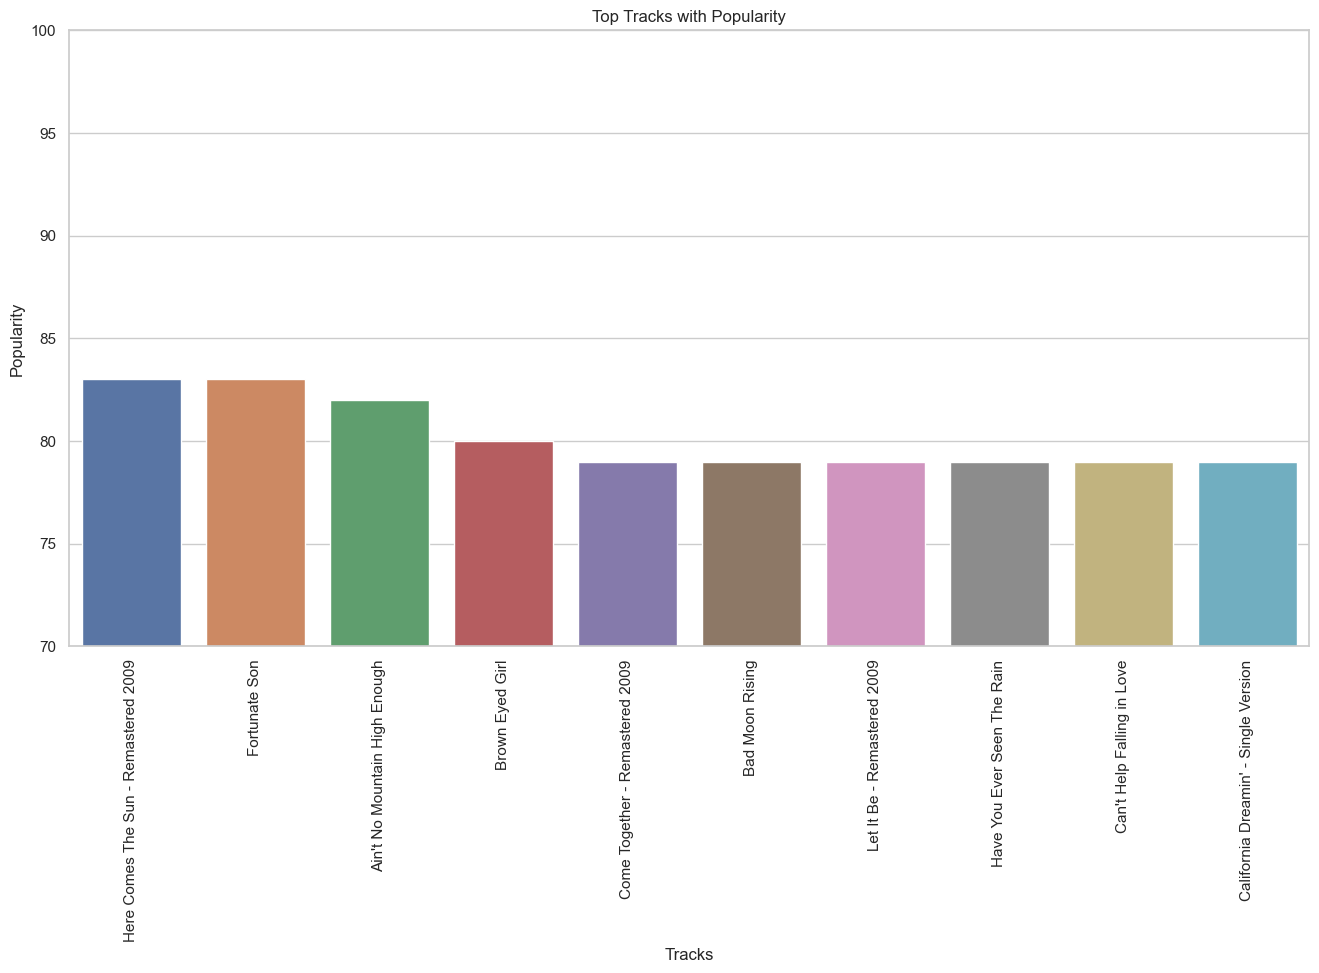

In [30]:
#Top Tracks with Popularity
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
y = x1.groupby("name")["popularity"].mean().sort_values(ascending=False).head(10)
ax = sns.barplot(x=y.index,y=y)
ax.set_title('Top Tracks with Popularity')
ax.set_ylabel('Popularity')
ax.set_xlabel('Tracks')
ax.set_ylim(70,100)
plt.xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'NormanGreenbaum'),
  Text(1, 0, 'TheFoundations'),
  Text(2, 0, 'FrankSinatraNancySinatra'),
  Text(3, 0, 'Free'),
  Text(4, 0, 'JamesBrownTheFamousFlames'),
  Text(5, 0, 'FrankieValli'),
  Text(6, 0, 'TheRighteousBrothers'),
  Text(7, 0, 'DavidBowie'),
  Text(8, 0, 'MungoJerry'),
  Text(9, 0, 'MarvinGaye')])

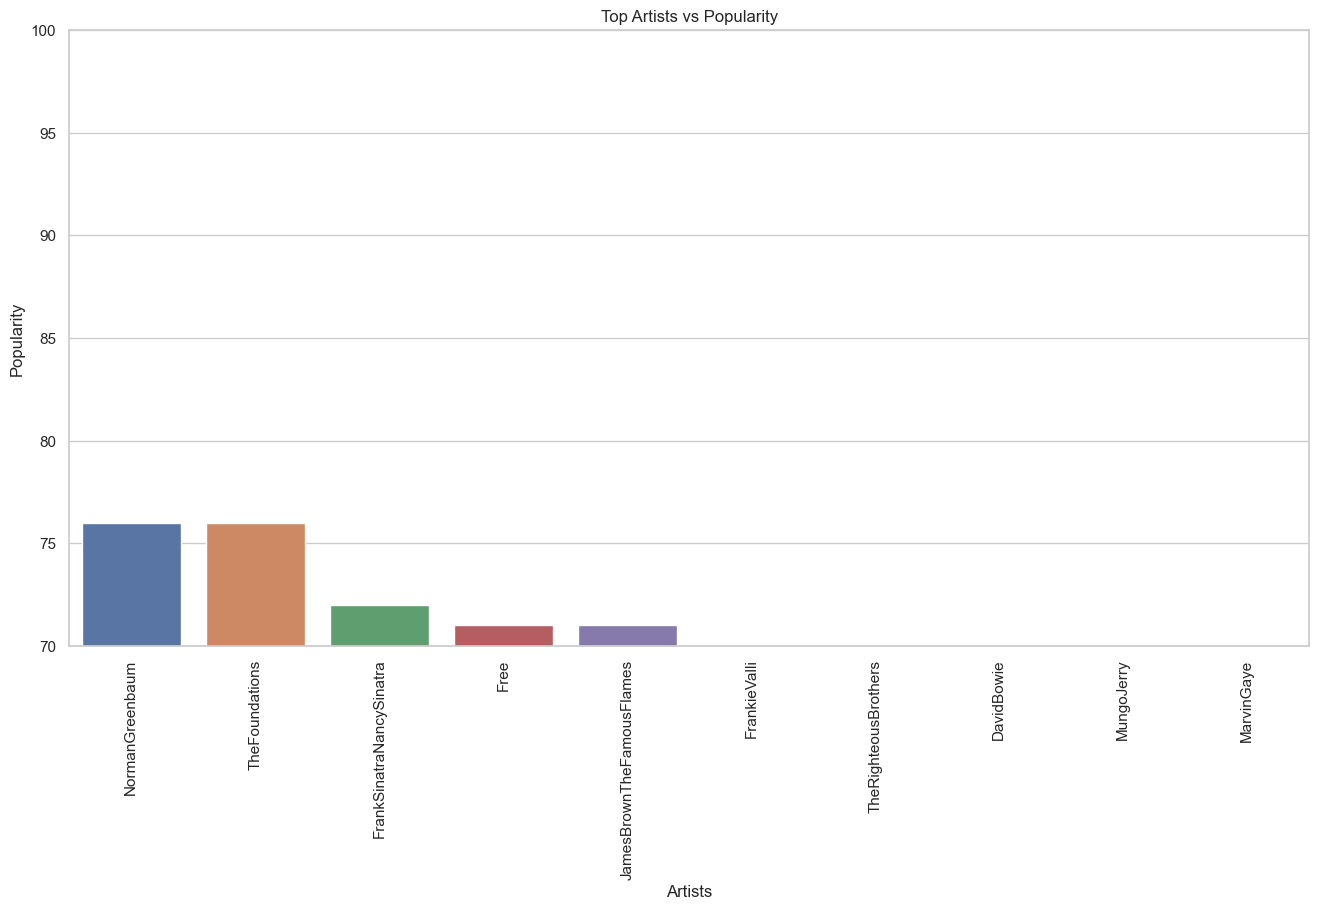

In [31]:
#Top Artists vs Popularity
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
y2 = x1.groupby("artists")["popularity"].mean().sort_values(ascending=False).head(10)
ax = sns.barplot(x=y2.index,y=y2)
ax.set_title('Top Artists vs Popularity')
ax.set_ylabel('Popularity')
ax.set_xlabel('Artists')
ax.set_ylim(70,100)
plt.xticks(rotation = 90)

In [32]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import MaxAbsScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
import pandas as pd


df = df_stream
assembler = VectorAssembler(inputCols = pca_col, outputCol = 'features')
df1 = assembler.transform(df.na.drop("any"))

scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(df1)


scaledData = scaler.transform(df1)

a = scaledData.select('scaledFeatures')

pca = PCA(k=10,inputCol="scaledFeatures", outputCol="pcaFeatures").fit(scaledData)

df_pca = pca.transform(scaledData)

df3 = df_pca.select('pcaFeatures')

# Trains a k-means model.
kmeans = KMeans(k=4)
model = kmeans.fit(df_pca)

# Make predictions
predictions = model.transform(df_pca)



from  pyspark.ml.linalg import Vectors
temp = predictions.select("pcaFeatures")
temp = temp.rdd.map(lambda x: [float(y) for y in x['pcaFeatures']]).toDF(['PC1'])




pandas_df = temp.toPandas()
predictions_df = predictions.toPandas()

pred = predictions_df['prediction']

final_df = pd.concat([pandas_df,pred],axis =1)

df_pca_res = spark.createDataFrame(final_df)

df_pca_res.show(5)

+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+----------+
|                PC1|                  _2|                 _3|                 _4|                  _5|                  _6|                 _7|                  _8|                 _9|                 _10|prediction|
+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+----------+
|  1.060351149683782|-0.32325995873787344|  1.315192874897298|0.29706344109549726|-0.17681566043876587|  0.8210568429413891| 0.6530322660200559|-0.39817451273033405|-0.7639766956838362| 0.42401587392057416|         1|
|-2.0298068898479737|   0.880444665493364|  1.333146279028231|0.30930002324224337| -0.4963640497474042|   0.502400230817985| 0.6

In [33]:
pca.explainedVariance

DenseVector([0.2798, 0.1305, 0.1112, 0.1016, 0.0995, 0.0906, 0.0824, 0.0556, 0.0339, 0.0148])

In [36]:
#pip install --upgrade nbformat if ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed show up and restart kernel
import plotly.express as px
fig = px.scatter_3d(final_df, x="PC1", y="_2",z ="_3", color="prediction")
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed